# Modelo: Boosting

El modelo a entrenar en el sigueinte notebook se ra un ensamble. En particular buscaremos hacer un boosting con árboles de decisión. Para ello utilizaremos GradientBoostingClassifier de sklearn

## Librerias y funciones necesarias

Comenzamos importando las librerias y funciones que serán necesarias para preprocesar nuestros datos, realizar nuestro entrenamiento y obtener metricas 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import tree


In [2]:
from preprocessing import obtener_datasets
from preprocessing import aplicar_preparacion
from preprocessing import conversion_numerica
from preprocessing import plot_roc_curves
from preprocessing import graficar_matriz_confusion
from preprocessing import aplicar_preparacion_generalizado
from preprocessing import conversion_numerica_generalizada
from preprocessing import get_dataframe_scaled
from preprocessing import reduccion_rfecv
from preprocessing import get_dataframe_polynomial

## Primer preprocesamiento

En primer lugar obtenemos el dataset para entrenar y el holdout. En segundo lugar, aplicamos una función que trabaja sobre las features, generalizando algunas y dejando de lado otras según lo observado en la primer parte de este trabajo práctico. También separamos a la variable target del resto del dataset. Por último, convertimos a númericas las variables categoricas para poder entrenar nuestro modelo

In [3]:
df, df_holdout = obtener_datasets()
X_df, y_df = aplicar_preparacion(df)
X_df = conversion_numerica(X_df) 

Aplicando 'conversion_numerica' en las variables categóricas.


Luego vamos a realizar un split del dataset para dividir en train y test. Como observamos en la primer parte de este trabajo práctico, la variable target no esta distribuida uniformente por lo cual realizamos una división estratificada

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=30,stratify=y_df)

### Entrenamiento

Vamos a realizar un entrenamiento con 5 folds. Para ello utilizaremos StratifieadKFold para asegurarnos de obtener folds balanceados. Además, utilizaremos Gridsearch para la busqueda de hiperparámetros óptimos teniendo en cuenta la métria AUC-ROC.

In [5]:
cv = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(X_train, y_train)
clf = GradientBoostingClassifier(random_state=10)
params = {"max_depth":np.arange(3,8),"min_samples_leaf":np.arange(50,150,20)}
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv, n_jobs = -1)


Ahora sí, entrenamos nuestro modelo

In [6]:
clf.fit(X_train, y_train)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fa8f2ac1d60>,
             estimator=GradientBoostingClassifier(random_state=10), n_jobs=-1,
             param_grid={'max_depth': array([3, 4, 5, 6, 7]),
                         'min_samples_leaf': array([ 50,  70,  90, 110, 130])},
             scoring='roc_auc')

Realizamos nuestras predicciones para una análisis más amplio

In [7]:
y_pred = clf.predict(X_test)

### Metricas

AUC-ROC score sobre test:  0.9296294958832876
AUC-ROC score sobre train:  0.9408900908373998
Accuracy sobre test:  0.8719484108705665
Accuracy sobre train:  0.8802595208845209
              precision    recall  f1-score   support

  Bajo valor       0.94      0.89      0.92      5207
  Alto valor       0.65      0.78      0.71      1306

    accuracy                           0.87      6513
   macro avg       0.80      0.84      0.81      6513
weighted avg       0.88      0.87      0.88      6513

Los mejores hiperpametros elegidos:  {'max_depth': 7, 'min_samples_leaf': 50}


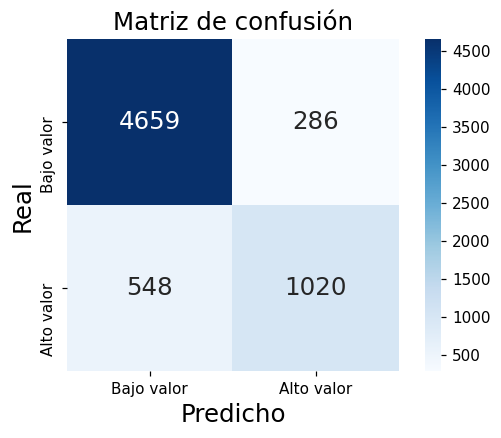

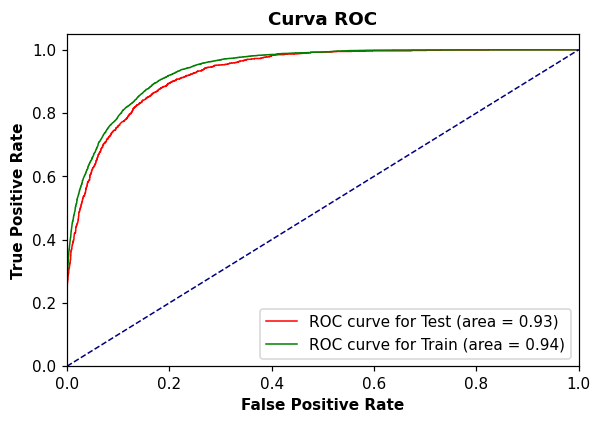

In [9]:
print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Accuracy sobre train: ", "%0.16f"  % accuracy_score(clf.predict(X_train), y_train))
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf, X_test, y_test, X_train, y_train)

Obtenemos buenas métricas a nivel general y además la brecha entre el test y el train parece ser lógica por lo que entendemos no estariamos overfitteado (algo que al usar aŕboles lógicamente hay que cuidar). Probemos igualmente otro preprocesamiento apra ver si obtenemos algo diferente

## Segundo preprocesamiento

Realizamos nuesttro nuevo preprocesado. En este caso se trata de una modificación mas leve a nuestras features en donde no agruparemos como lo hicimos en el primer preprocesado (por ejemplo en la educación). Además, tendremos en cuenta a la feature barrio, generalizando entre los residente en Palermo y los no residentes en Palermo. También, escalamos las variables con Standard Scaler

In [3]:
df, df_holdout = obtener_datasets()
X_df, y_df = aplicar_preparacion_generalizado(df)
X_df = conversion_numerica_generalizada(X_df)
X_df = get_dataframe_polynomial(X_df, 3, True)


Aplicando 'conversion_numerica_generalizada' en las variables categóricas.
Dataset inicial con 43 features...
Dataset nuevo con PolynomialFeature con 53 features...


Realizamos nuevamente el split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=30,stratify=y_df)

Y escalamos

### Entrenamiento

Volvemos a realizar un entrenamiento con 5 folds, utilizando las mismas librerias y funciones utilizadas anteriormente

In [5]:
cv = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(X_train, y_train)
clf_2 = GradientBoostingClassifier(random_state=10)
params = {"max_depth":np.arange(3,8),"min_samples_leaf":np.arange(50,150,20)}
clf_2 = GridSearchCV(clf_2, params, scoring='roc_auc', cv=cv, n_jobs = -1)


In [6]:
clf_2 = tree.DecisionTreeClassifier(random_state=10, criterion = 'gini', max_depth = 7, min_samples_leaf =50)
X_reducido = reduccion_rfecv(
    estimator=clf_2,
    X_df = X_df,
    y_df = y_df,
    min_features_to_select=20,
    step=5,
    n_jobs=-1,
    scoring="roc_auc",
    cv=5
)

X_reducido = get_dataframe_polynomial(X_reducido, 2, False)
X_train, X_test, y_train, y_test = train_test_split(X_reducido, y_df, random_state=10, test_size=0.20, stratify=y_df)
X_train = get_dataframe_scaled(X_train,StandardScaler())
X_test = get_dataframe_scaled(X_test,StandardScaler())
clf_2 = GradientBoostingClassifier(random_state=10,max_depth=7,min_samples_leaf=50)

Dataset inicial con 20 features...
Dataset nuevo con PolynomialFeature con 30 features...


Entrenamos nuestro modelo

In [6]:
clf_2.fit(X_train, y_train)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f0bdcf9f7b0>,
             estimator=GradientBoostingClassifier(random_state=10), n_jobs=-1,
             param_grid={'max_depth': array([3, 4, 5, 6, 7]),
                         'min_samples_leaf': array([ 50,  70,  90, 110, 130])},
             scoring='roc_auc')

Realizamos nuestras predicciones para una análisis más amplio

In [7]:
y_pred = clf_2.predict(X_test)

### Metricas

AUC-ROC score sobre test:  0.9279066543199687
AUC-ROC score sobre train:  0.9449451152502155
Accuracy sobre test:  0.8704130201136189
Accuracy sobre train:  0.8869778869778869
              precision    recall  f1-score   support

  Bajo valor       0.94      0.89      0.92      5223
  Alto valor       0.64      0.78      0.70      1290

    accuracy                           0.87      6513
   macro avg       0.79      0.84      0.81      6513
weighted avg       0.88      0.87      0.87      6513



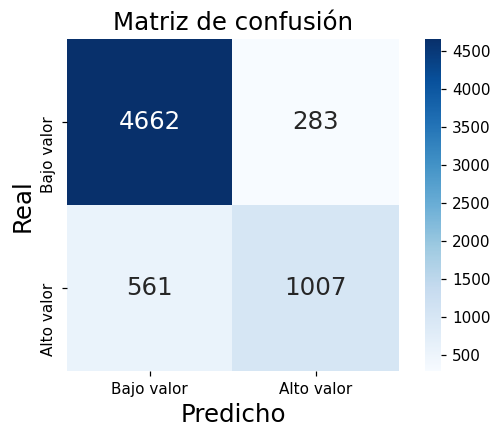

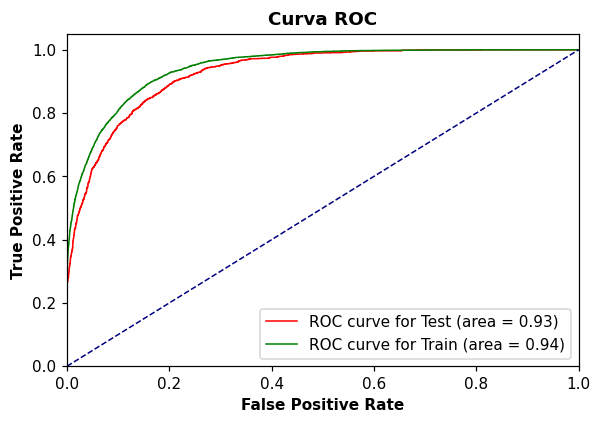

In [8]:
print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf_2.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf_2.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Accuracy sobre train: ", "%0.16f"  % accuracy_score(clf_2.predict(X_train), y_train))
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
#print("Los mejores hiperpametros elegidos: ", clf_2.best_params_)
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf_2, X_test, y_test, X_train, y_train)

Obtenemos buenas métricas a nivel general y además la brecha entre el test y el train parece ser lógica por lo que entendemos no estariamos overfitteado (algo que al usar aŕboles lógicamente hay que cuidar). Probemos igualmente otro preprocesamiento apra ver si obtenemos algo diferente

## Holdouts

Realizamos los testeos requeridos en el holdout